#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-полученных-данных" data-toc-modified-id="Анализ-полученных-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ полученных данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес-решающих-деревьев." data-toc-modified-id="Случайный-лес-решающих-деревьев.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес решающих деревьев.</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Анализ-полученных-данных" data-toc-modified-id="Анализ-полученных-данных-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Анализ полученных данных</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

<h1>Описание проекта</h1>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

Для начала посмотрим, какие данные передал заказчик и убедимся, что в них нет дефектов( например пропусков).

In [2]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.7 MB/s eta 0:00:00


In [3]:
# загрузка данных
!wget https://***/datasets/taxi.csv

--2023-03-31 17:46:54--  https://***/datasets/taxi.csv
Resolving *** (***)... 93.158.134.158, 2a02:6b8::2:158
Connecting to *** (***)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600308 (586K) [application/octet-stream]
Saving to: ‘taxi.csv’

taxi.csv            100%[===================>] 586.24K   518KB/s    in 1.1s    

2023-03-31 17:46:56 (518 KB/s) - ‘taxi.csv’ saved [600308/600308]



In [4]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data.sort_index(inplace=True)

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Нами получен файл с количеством заказов и временем замера. Время замера является индексом строки с количеством заявок. Замеры проводятся каждые 10 минут во временном периоде с 00\:00\:00 1 марта 2018 года по 23\:50\:00 31 августа 2018 года.

Теперь можем перейти к обработке данных. Увеличим интервалы между замерами до 1 часа.

In [8]:
data = data.resample('1H').sum()

In [9]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Выделим календарные признаки в виде месяца, дня, дня недели и часа нашего диапазона в отдельные столбцы. Также добавим в таблицу отстающие значения и добавим скользящее среднее, таким образом мы увидим направление изменения значения и  общий тренд временного ряда. Смещение выберем и размер для скользящего среднего равными 12.

In [10]:
data_sorted = data.copy()
data_sorted['month'] = data_sorted.index.month
data_sorted['day'] = data_sorted.index.day
data_sorted['dayofweek'] = data_sorted.index.dayofweek
data_sorted['hour'] = data_sorted.index.hour

In [11]:
for lag in range(1, 25):
    data_sorted['lag_{}'.format(lag)] = data_sorted['num_orders'].shift(lag)

In [12]:
data_sorted['rolling_mean'] = data_sorted['num_orders'].shift()\
                              .rolling(24).mean().round()

In [13]:
data_sorted = data_sorted.dropna()

In [14]:
data_sorted.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,57.0
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.0
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,57.0
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.0
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,57.0
2018-03-02 05:00:00,11,3,2,4,5,20.0,64.0,75.0,120.0,90.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,56.0
2018-03-02 06:00:00,11,3,2,4,6,11.0,20.0,64.0,75.0,120.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,56.0
2018-03-02 07:00:00,7,3,2,4,7,11.0,11.0,20.0,64.0,75.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,56.0
2018-03-02 08:00:00,46,3,2,4,8,7.0,11.0,11.0,20.0,64.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,56.0


## Анализ полученных данных

In [15]:
def visual(dec, x, titl):
    plt.subplot(x)
    dec.plot(grid=True, figsize=(12, 10))
    plt.title(titl + '. Распределение значений')
    plt.xlabel('временной период')
    plt.ylabel('заказы')
    plt.show()  

In [16]:
decomposed = seasonal_decompose(data)

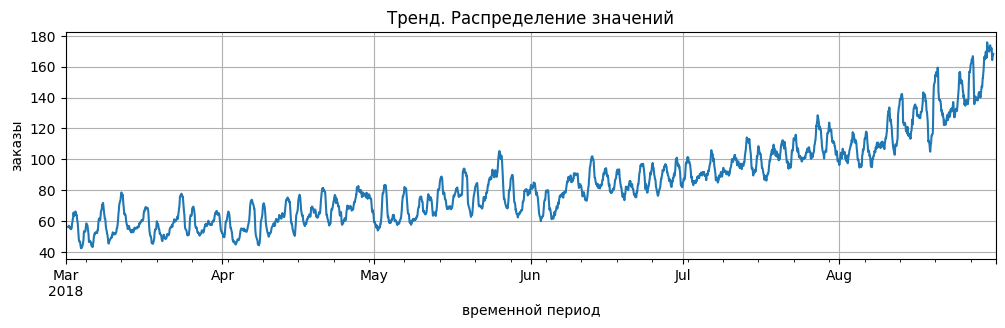

In [17]:
visual(decomposed.trend, 311, 'Тренд')

Можно заметить, как на протяжении всего периодаколичество заказов возрастает.

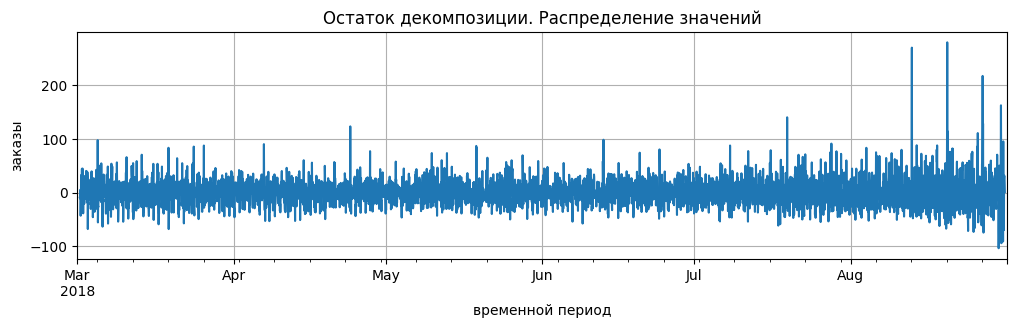

In [18]:
visual(decomposed.resid, 311, 'Остаток декомпозиции')

Также, количество выбивающихся значений во второй половине августа заментно увеличивается. Скорее всего, это связано с прилетами семей с детьми и студетнов перед началом учебного года.

Рассмотрим сезонность месяца, недели и дня на примере марта.

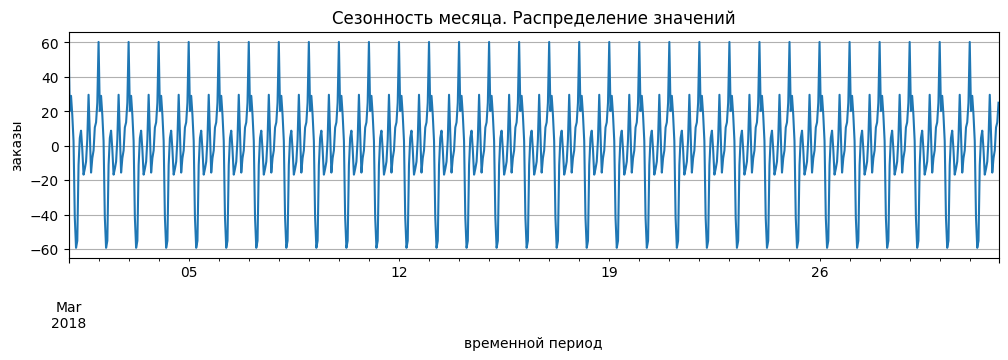

In [19]:
visual(decomposed.seasonal.head(24*31), 311, 'Сезонность месяца')

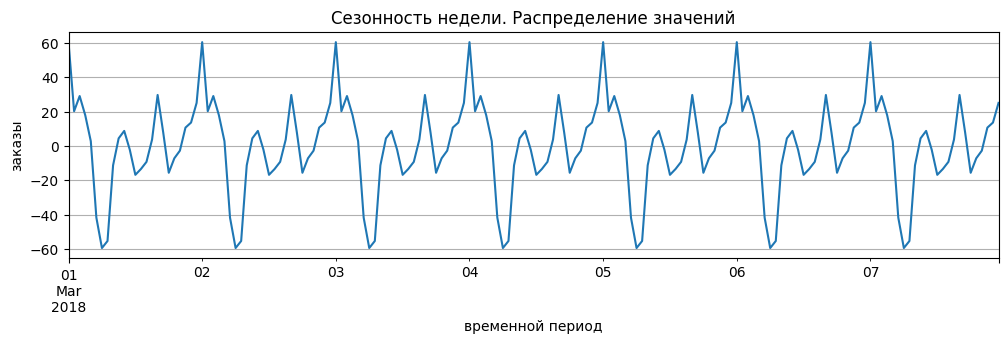

In [20]:
visual(decomposed.seasonal.head(24*7), 311, 'Сезонность недели')

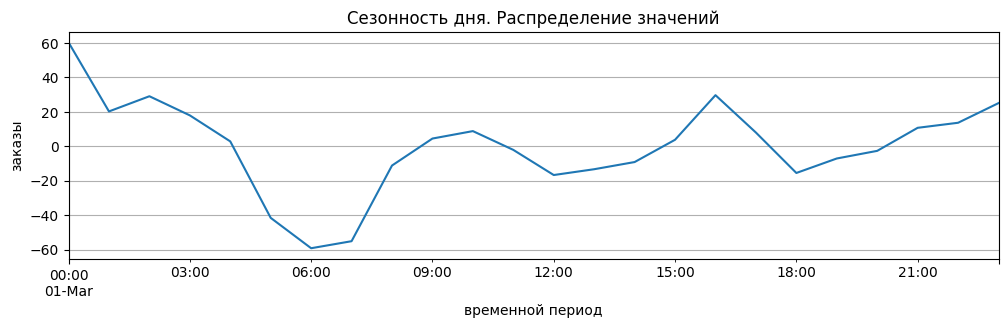

In [21]:
visual(decomposed.seasonal.head(24), 311, 'Сезонность дня')

На графиках можно увидеть, что повторяющийся период составляет 1 день. Количество заказов в районе 6 утра снижается, а в районе с 22 до 3 ночи и с 15 до 17 дня на оборот повышается.

Посмотрим, не изменятся ли результаты на медианных значениях всего периода. Для этого построим теже графики для медианных значений соответствующих периодов.

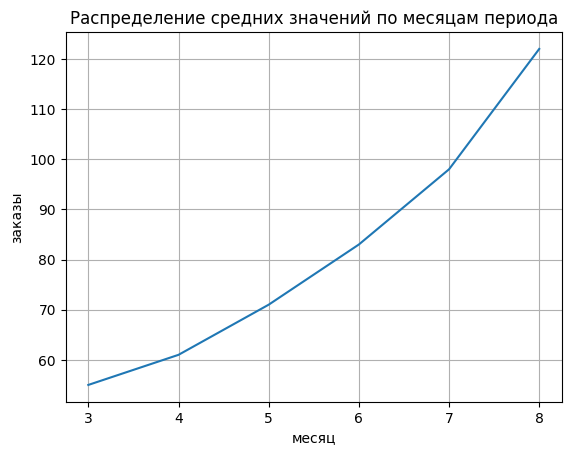

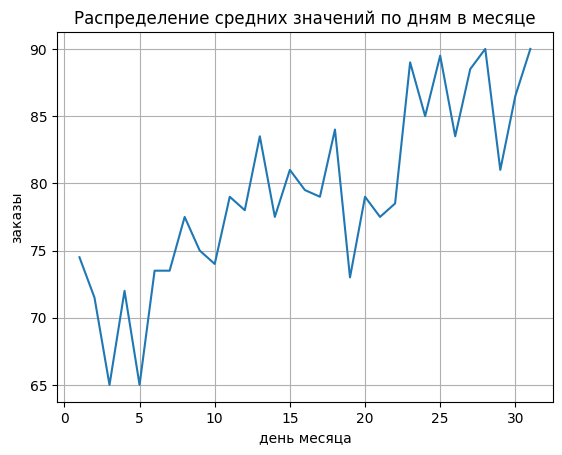

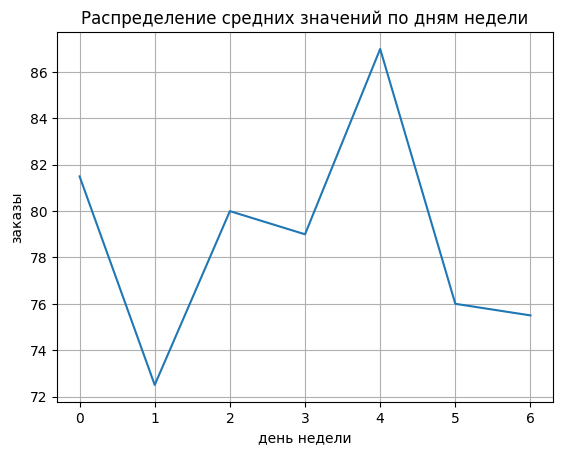

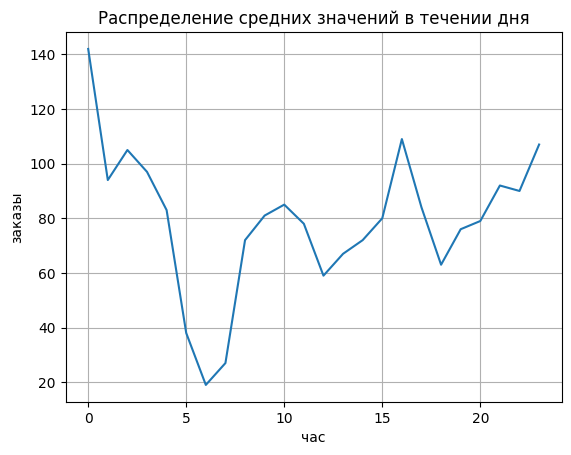

In [22]:
for t in ['month', 'day', 'dayofweek', 'hour']:
    data_sorted.groupby(t)['num_orders'].median().plot(grid=True)
    if t == 'month':
        plt.title('Распределение средних значений по месяцам периода')
        plt.xlabel('месяц')
    elif t == 'day':
        plt.title('Распределение средних значений по дням в месяце')
        plt.xlabel('день месяца')
    elif t == 'dayofweek':
        plt.title('Распределение средних значений по дням недели')
        plt.xlabel('день недели')
    elif t == 'hour':
        plt.title('Распределение средних значений в течении дня')
        plt.xlabel('час')
    plt.ylabel('заказы')
    plt.show()

По средним(медианным) значениям получается, что заказов «Чётенькое такси» становится всё больше с каждым месяцем, так же в среднем 3-5 и 19-22 числа каждого месяца происходит меньше заказов. Люди чаще заказывают такси из аэропорта по понедельникам и пятницам, а вот по вторникам и воскресеньям количество заказов значительно ниже. В среднем на протяжении дня пик заказов приходится на ночное время ( с 20 часов до 4 часов), днем же чаще заказывают такси в районе 10 утра и в районе 16 часов. Меньше всего заказов в течение дня приходится на период с 4 до 7 утра.

Теперь можно перейти к обучению моделей.

## Обучение моделей

Так как в ходе анализа были выявлены явные связи количества заказов со временем и днем недели для обучения выберем следующие модели для обучения - линейную, решающий лес, catboost и гардиентный бустинг. В качестве метрики качества будем использовать RMSE(среднеквадратичное откланение).

Разобьем данные на обучающие и тестовые выборки в соотношении 9:1 и выделим целевой признак.

In [23]:
train, test = train_test_split(data_sorted, 
                               shuffle=False, 
                               test_size=0.1)

In [24]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [25]:
def r_mse(t_tr, p_tr):
    return mse(t_tr, p_tr)**0.5

In [26]:
# функция обучения модели
def model_scorer(f_tr, t_tr, model, param):
       
    grid_CV = GridSearchCV(estimator = model, param_grid = param, 
                           scoring='neg_mean_squared_error', 
                           cv=TimeSeriesSplit(n_splits=5))

    grid_CV.fit(f_tr, t_tr)

    model_gcv = grid_CV.best_estimator_
    rmse = (-grid_CV.best_score_) ** 0.5 
    
    print('Модель проверена. Лучшее значение по результатам кросс-валидации -',
              '%.2f' %rmse, '.')
    
    return model_gcv, rmse

### Линейная регрессия

Обучим модель линейной регрессии.

In [27]:
%%time
param_set = {}
model_lr, rmse_lr_k = model_scorer(features_train, target_train,
                                   LinearRegression(), param_set)

Модель проверена. Лучшее значение по результатам кросс-валидации - 27.17 .
CPU times: user 123 ms, sys: 242 ms, total: 365 ms
Wall time: 240 ms


### Случайный лес решающих деревьев.

Для обучения данной модели потребуется перебор гипер параметров. Это может занять какое-то время.

In [28]:
%%time
param_set = {'n_estimators' : range(140, 181, 20),
             'max_depth' : range(18, 25, 2)
            }
model_rfr, rmse_rfr = model_scorer(features_train, target_train,
                                   RandomForestRegressor(
                                                  random_state=12345),
                                   param_set)

Модель проверена. Лучшее значение по результатам кросс-валидации - 25.48 .
CPU times: user 6min 6s, sys: 1.06 s, total: 6min 7s
Wall time: 6min 28s


### CatBoost

Следующей моделью рассмотрим CatBoost. 

In [33]:
%%time
cat_features = ['month', 'day', 'dayofweek', 'hour']

param_set = {
    'iterations': range(20, 61, 20),
    'depth': range(6, 11, 2),
    'learning_rate': np.logspace(-3, 0, 5)
             }

model_cb, rmse_cb = model_scorer(features_train, target_train,
                                 CatBoostRegressor(loss_function='RMSE',
                                                   silent=True,
                                                   random_seed=12345), 
                                 param_set)

Модель проверена. Лучшее значение по результатам кросс-валидации - 25.39 .
CPU times: user 5min 51s, sys: 10.8 s, total: 6min 1s
Wall time: 3min 42s


### LGBMRegressor

Последней рассмотрим модель LightGBM с градиентным бустингом.

In [34]:
%%time
param_set = {
    'n_estimators' : range(20, 101, 20),
    'max_depth' : range(6, 11, 2),
    'num_leaves' : [50, 65, 100]}

model_lgbm, rmse_lgbm = model_scorer(features_train, target_train,
                                     LGBMRegressor(boosting_type = 'gbdt', 
                                                   verbose = -1, 
                                                   random_state = 12345,
                                                   force_col_wise = True), 
                                     param_set)


Модель проверена. Лучшее значение по результатам кросс-валидации - 25.07 .
CPU times: user 59.9 s, sys: 1.45 s, total: 1min 1s
Wall time: 34.9 s


### Анализ полученных данных
Теперь сведем все полученные данные по моделям в одну таблицу. Так как количество заказов не может быть дробным числом, округлим значение параметра RMSE до целого.

In [35]:
pd.DataFrame([
    ['Линейная регрессия', math.ceil(rmse_lr_k)],
    ['Случайный лес решающих деревьев', math.ceil(rmse_rfr) ],
    ['CatBoost', math.ceil(rmse_cb)],
    ['LightGBM', math.ceil(rmse_lgbm)],
              ], columns=['Модель', 'RMSE'])

,Модель,RMSE
0,Линейная регрессия,28
1,Случайный лес решающих деревьев,26
2,CatBoost,26
3,LightGBM,26


Все модели имеют близкие результаты на кросс-валидации. Лучшее значение получено у модели LGBMRegressor. Проверим ее на тестовой выборке.

## Тестирование

In [36]:
test_preds = model_lgbm.predict(features_test)
rmse_test = r_mse(target_test, test_preds)

In [37]:
pd.DataFrame([
    ['LGBMRegressor', math.ceil(rmse_lgbm), math.ceil(rmse_test)],
              ], columns=['Модель', 'RMSE(обуч.)', 'RMSE(тест.)'])

,Модель,RMSE(обуч.),RMSE(тест.)
0,LGBMRegressor,26,43


Значение параметра качества на тестовой выборке снизилось, но всё ещё находится в перделах допустимого(RMSE<48). посмотрим распределение предсказаний и фактических значей.

In [38]:
# сбор результатов в один датафрейм
result = pd.DataFrame()
result['Предсказание'] = test_preds
datetime = target_test.index
result = result.set_index(datetime)
result['Фактическое значение'] = target_test

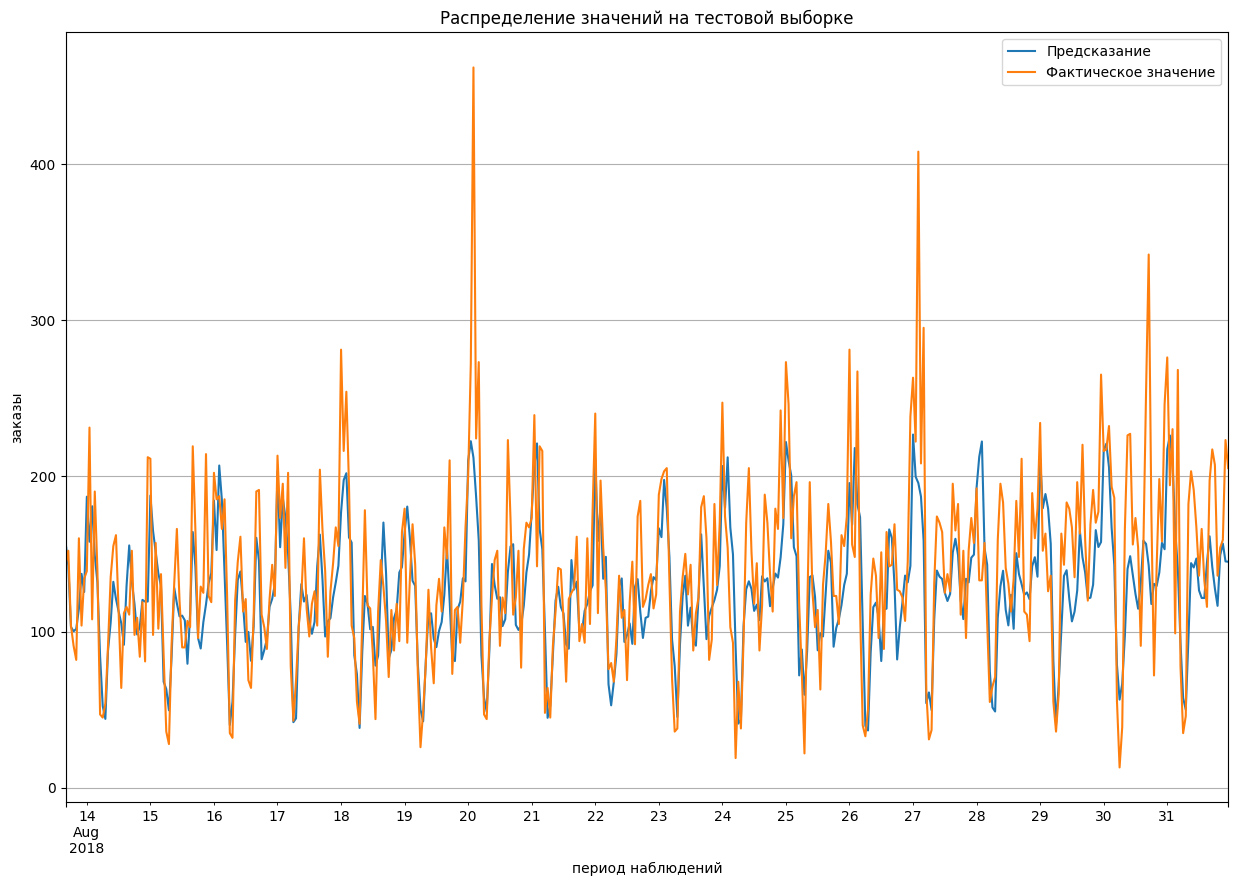

In [39]:
result['Предсказание'].plot(grid=True, figsize=(15, 10))
result['Фактическое значение'].plot(grid=True, figsize=(15, 10))

plt.title('Распределение значений на тестовой выборке')
plt.legend(['Предсказание', 'Фактическое значение'])
plt.xlabel('период наблюдений')
plt.ylabel('заказы')
plt.show()

На графике видно, предсказанные значения имеют меньше выбрасов, в отличие от фактических данных( например 20 и 27 августа). В остальном, предсказания имеют более плавный график значений.

## Вывод

По запросу компании «Чётенькое такси» было проведено исследование исторических данных компании за период с марта по август 2018 года включительнно. Данные содержали статистику количества заказов за каждые 10 минут предоставленного интервала. Также задача исследования разработать модель предсказания с точностью выбранной метрики качества до 48.


На первом этапе исследования был увеличен интервал замеров до часа. Затем были построены графики, отражающие статисттические данные общего тренда и сезонности значений. 

Затем пришло время перейти непосредственно к разработке модели предсказания. Для получения предсказаний были обучены 4 модели:
- линейная регрессия
- решающий лес 
- catboost
- LGBMRegressor

После обучения были получены следующие данные:

|Модель|RMSE|
|:----|:----:|
|Линейная регрессия | 27 |
|Случайный лес решающих деревьев | 26 |
|CatBoost | 26 |
|LightGBM | 26 |

Лучшие результаты были получены на модели LGBMRegressor. На тестовой выборке было получено следующее значение метрики качества:

- обучающие данные - 26
- тестовые данные - 43

Как видно, модель успешно предсказывает значения и готова к дальнейшему использованию.